In [ ]:
!pip install pafy youtube-dl moviepy

In [70]:
from tqdm import tqdm

In [1]:
# importing libraries

import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
# Set Numpy, Python and Tensorflow seeds to get consistent results.

seed_constant = 17
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
!ls

'1) Single & Average Frame CNN.ipynb'   index.ipynb
 Anomaly_Dataset		        index.ipynb.amltmp
 anomaly			        labels_data_4_class.npy
 crimeucfdataset.zip		        small_set_data_4_class.npy
 images_data_4_class.npy	        small_set_labels_4_class.npy
 inceptionv3+lstm.ipynb		        small_set_transfer_values_4_class.npy


In [4]:
dir_name = "Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2"
take_video = 15

In [5]:
[os.listdir(os.path.join(dir_name, dir))[:take_video] for dir in os.listdir(dir_name)]

[['Burglary001_x264.mp4',
  'Burglary002_x264.mp4',
  'Burglary003_x264.mp4',
  'Burglary004_x264.mp4',
  'Burglary005_x264.mp4',
  'Burglary006_x264.mp4',
  'Burglary007_x264.mp4',
  'Burglary008_x264.mp4',
  'Burglary009_x264.mp4',
  'Burglary010_x264.mp4',
  'Burglary011_x264.mp4',
  'Burglary012_x264.mp4',
  'Burglary013_x264.mp4',
  'Burglary014_x264.mp4',
  'Burglary015_x264.mp4'],
 ['Explosion001_x264.mp4',
  'Explosion002_x264.mp4',
  'Explosion003_x264.mp4',
  'Explosion004_x264.mp4',
  'Explosion005_x264.mp4',
  'Explosion006_x264.mp4',
  'Explosion007_x264.mp4',
  'Explosion008_x264.mp4',
  'Explosion009_x264.mp4',
  'Explosion010_x264.mp4',
  'Explosion011_x264.mp4',
  'Explosion012_x264.mp4',
  'Explosion013_x264.mp4',
  'Explosion014_x264.mp4',
  'Explosion015_x264.mp4'],
 ['Fighting002_x264.mp4',
  'Fighting003_x264.mp4',
  'Fighting004_x264.mp4',
  'Fighting005_x264.mp4',
  'Fighting006_x264.mp4',
  'Fighting007_x264.mp4',
  'Fighting008_x264.mp4',
  'Fighting009_x264.m

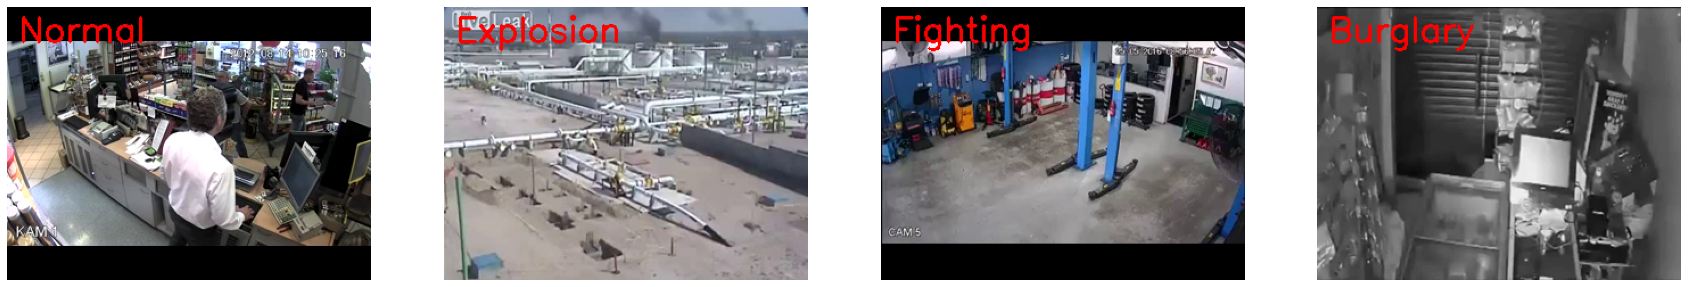

In [6]:
# Visualize the Data with its Labels

# Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir(dir_name)

# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 4)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'{dir_name}/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'{dir_name}/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [7]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = dir_name
classes_list = os.listdir(dir_name)

model_output_size = len(classes_list)

In [8]:
model_output_size

4

In [9]:
# Extract, Resize and Normalize Frames

def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [10]:
# Dataset Creation

def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))[:take_video]

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)
            print(video_file_path)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)
            print(len(frames))

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [11]:
features, labels = create_dataset()

Extracting Data of Class: Burglary
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary001_x264.mp4
3969
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary002_x264.mp4
3064
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary003_x264.mp4
1173
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary004_x264.mp4
1787
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary005_x264.mp4
7729
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary006_x264.mp4
8937
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary007_x264.mp4
1085
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary008_x264.mp4
4920
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary009_x264.mp4
2557
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary010_x264.mp4
5888
Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Burglary/Burglary011_x264.mp4
19

In [12]:
features.shape, labels.shape

((32000, 64, 64, 3), (32000,))

In [13]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

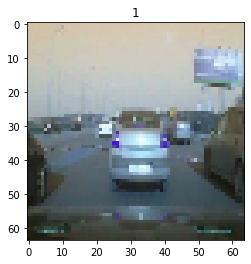

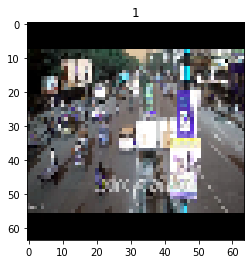

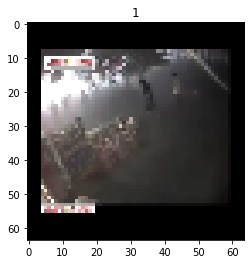

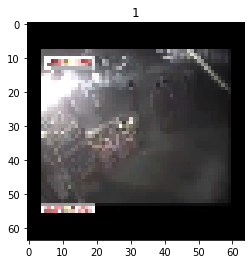

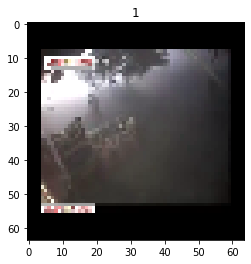

In [14]:
for i in range(15000, 15005):
  plt.imshow(features[i])
  plt.title(labels[i])
  plt.show()

In [15]:
# Split the Data into Train and Test Sets 

features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, 
                                                                            test_size = 0.2, shuffle = True, random_state = seed_constant)

In [16]:
# Construct the model

# Let's create a function that will construct our model
def create_model():

    # We will use a Sequential model for model construction
    model = Sequential()

    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [17]:
# Compile and Train the Model

# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 15, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/15
5120/5120 [==============================] - 194s 38ms/step - loss: 0.5986 - accuracy: 0.7736 - val_loss: 2.3046 - val_accuracy: 0.5279
Epoch 2/15
5120/5120 [==============================] - 215s 42ms/step - loss: 0.2338 - accuracy: 0.9222 - val_loss: 0.1210 - val_accuracy: 0.9693
Epoch 3/15
5120/5120 [==============================] - 192s 37ms/step - loss: 0.1600 - accuracy: 0.9473 - val_loss: 0.3358 - val_accuracy: 0.9191
Epoch 4/15
5120/5120 [==============================] - 168s 33ms/step - loss: 0.1286 - accuracy: 0.9607 - val_loss: 0.0587 - val_accuracy: 0.9955
Epoch 5/15
5120/5120 [==============================] - 168s 33ms/step - loss: 0.1082 - accuracy: 0.9677 - val_loss: 0.3562 - val_accuracy: 0.9150
Epoch 6/15
5120/5120 [==============================] - 168s 33ms/step - loss: 0.0997 - accuracy: 0.9697 - val_loss: 0.0838 - val_accuracy: 0.9824
Epoch 7/15
5120/5120 [==============================] - 167s 33ms/step - loss: 0.0903 - accuracy: 0.9732 - val_loss: 0

In [18]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 10s 52ms/step - loss: 0.0198 - accuracy: 0.9945


In [19]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

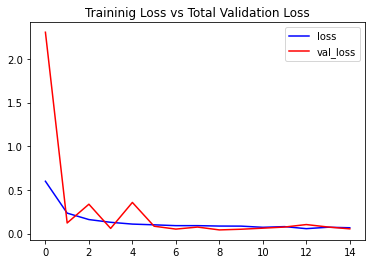

In [23]:
plot_metric('loss', 'val_loss', 'Traininig Loss vs Total Validation Loss')


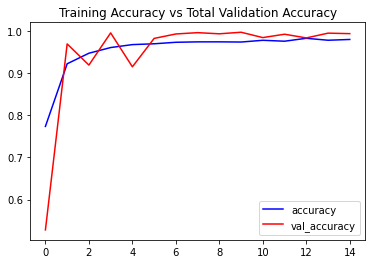

In [24]:
plot_metric('accuracy', 'val_accuracy', 'Training Accuracy vs Total Validation Accuracy')

In [25]:
# download youtube video
def download_youtube_videos(youtube_video_url, output_directory):
    # Creating a Video object which includes useful information regarding the youtube video.
    video = pafy.new(youtube_video_url)

    # Getting the best available quality object for the youtube video.
    video_best = video.getbest()

    # Constructing the Output File Path
    output_file_path = f'{output_directory}/{video.title}.mp4'

    # Downloading the youtube video at the best available quality.
    video_best.download(filepath = output_file_path, quiet = True)

    # Returning Video Title
    return video.title

In [73]:
# testing ................

def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
            # print(predicted_class_name)
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)
    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [ ]:
# saving model

model_json = model.to_json()
with open("SingleFrameCNN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("SingleFrameCNN.h5")
print("Saved model to disk")

In [40]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
video_title = download_youtube_videos('https://youtu.be/oKFupx9x0-k', output_directory)

# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [41]:
input_video_file_path, output_directory

('Youtube_Videos/RAW VIDEO: Beirut blast caught on camera.mp4',
 'Youtube_Videos')

In [66]:
dir_name_ ="anomaly/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2"
video_path_ = os.path.join(dir_name_, os.listdir(dir_name)[2])
full_path = os.path.join(video_path_, os.listdir(video_path_)[5:6][0])
full_path

'anomaly/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2/Fighting/Fighting007_x264.mp4'

In [75]:
input_video_file_path = "Youtube_Videos/Test Video.mp4"
video_title = "Average_Output_normal"


In [79]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 25

# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
# VideoFileClip(output_video_file_path).ipython_display(width = 700)

In [82]:
rounded_prediction = model.predict(features_test)

In [85]:
prediction = np.argmax(rounded_prediction, axis=1)

In [93]:
prediction

array([0, 3, 2, ..., 3, 2, 3])

In [96]:
test_labels = np.argmax(labels_test, axis=1)
test_labels

array([0, 3, 2, ..., 3, 2, 3])

In [105]:
# creating confusion matrix

from sklearn.metrics import confusion_matrix
import itertools    


In [97]:
cm = confusion_matrix(y_true=test_labels, y_pred=prediction)

In [99]:
print(cm)

[[1623   19    0    1]
 [   6 1534    4    4]
 [   0    1 1604    0]
 [   0    0    0 1604]]


In [100]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [101]:
classes= all_classes_names
classes

['Burglary', 'Explosion', 'Fighting', 'Normal']

Confusion matrix, without normalization
[[1623   19    0    1]
 [   6 1534    4    4]
 [   0    1 1604    0]
 [   0    0    0 1604]]


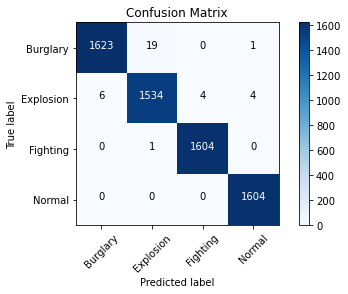

In [106]:
plot_confusion_matrix(cm, classes,  title='Confusion Matrix', cmap=plt.cm.Blues)